 # <center> PROJET NLP ENSAE 2020 - TOXIC COMMENT CLASSIFICATION </center> 
<center> Eléonore BLANCHARD, Yannick LY </center>

---

## <u> **Description du sujet** </u>

<h5 align='justify'>Avec la forte montée des réseaux sociaux et de par l'anonymat d'internet, nous observons une hausse de commentaires toxiques et du harcèlement en ligne. Certains d'entre eux étant même illégaux du fait de leur caractère raciste, homophobe, pédophile, etc. C'est pourquoi il est important que les plateformes en ligne modèrent ce type de commentaires et appliquent des sanctions comme le bannissement de la plateforme ou encore transmission de l'adresse IP aux autorités compétentes. Cependant les plateformes en ligne ont encore du mal à identifier correctement ces commentaires notamment son type de toxicité (toxique, très toxique, obscène, menace, insulte, haine identitaire). Pouvoir identifier le type de toxicité permettrait alors de pouvoir appliquer des mesures adéquates. Nous cherchons alors à construire un modèle multi-label permettant de détecter le type ou les types de toxicité. Nous utiliserons un data set issu de commentaires provenant de Wikipédia.</h5>







##  **<u>0 - Introduction</u>** 

<h5 align='justify'>Dans cette partie introductive, nous allons importer les librairies nécessaires au projet, télécharger nos données et effectuer une présentation de nos données. </h5>

In [0]:
# Basics
import numpy as np
import pandas as pd

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# NLP
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer, TweetTokenizer, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation

# Tools
from functools import reduce
from operator import add
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#from gensim.models import LdaModel
#from gensim import corpora
#import pyLDAvis.gensim

### **<u>0 - Téléchargement du set de données et des packages</u>**

In [0]:
!wget -c https://github.com/YannickLy/NLP-Project-ENSAE-2020/blob/master/Data/Data.zip?raw=true -O Data.zip
!unzip Data.zip

--2020-04-12 18:55:52--  https://github.com/YannickLy/NLP-Project-ENSAE-2020/blob/master/Data/Data.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YannickLy/NLP-Project-ENSAE-2020/raw/master/Data/Data.zip [following]
--2020-04-12 18:55:53--  https://github.com/YannickLy/NLP-Project-ENSAE-2020/raw/master/Data/Data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YannickLy/NLP-Project-ENSAE-2020/master/Data/Data.zip [following]
--2020-04-12 18:55:53--  https://raw.githubusercontent.com/YannickLy/NLP-Project-ENSAE-2020/master/Data/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **<u>0 - Description du set de données</u>**


In [0]:
train = pd.read_csv('Data/train.csv')
X_train = train[['id', 'comment_text']]
y_train = train[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_test = pd.read_csv('Data/test.csv')
y_test = pd.read_csv('Data/test_labels.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Le data set est composé de 8 colonnes :
* `id`: ID unique afin d'identifier le commentaire
* `comment_text` : le texte du commentaire
* `toxic` : le commentaire comporte t-il un caractère toxique ? (1 si oui, 0 si non)
* `severe_toxic` : le commentaire comporte t-il un caractère très toxique ? (1 si oui, 0 si non)
* `obscene` : le commentaire comporte t-il un caractère obscène ? (1 si oui, 0 si non)
* `threat` : le commentaire comporte t-il une menace ? (1 si oui, 0 si non)
* `insult` : le commentaire comporte t-il une insulte ? (1 si oui, 0 si non)
* `identity_hate` : le commentaire comporte t-il un caractère de haine identitaire ? (1 si oui, 0 si non)

Le data set est composé de 159 171 commentaires qui ont été labellisés par des humains, des erreurs de labellisations sont alors possibles. Certains commentaires disposent de plusieurs labels.

Afin de mieux comprendre ce que chaque label (`toxic`, `severe_toxic`, `obscene`,  `threat`, `insult`, `identity_hate`) signifie, nous allons afficher un exemple pour chacun :

<u>Toxic comment :</u>

In [0]:
print(train[(train.toxic==1) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


<u>Severe toxic comment :</u> 

In [0]:
print(train[(train.toxic==1) & (train.severe_toxic==1) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

so everytime i reset my modem my ip changes

fuck you petty sexless ugly ass desperate no life.. no status in society anal retentive wiki admins

(the site is great.. but the lower level admins have no life and can't handle the little authority they have.. it tells you how small and pathetic their lives are)

if i get blocked ill be on in 20 seconds with a new ip or the pizza is free.

cheers.


<u> Obscene comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==1) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

How do you know he is dead.  Its just his plane that crashed.  Jeezz, quit busting his nuts, folks.


<u> Threat comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==1) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

Please stop. If you continue to ignore our policies by introducing inappropriate pages to Wikipedia, you will be blocked.


<u> Insult comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==1) & (train.identity_hate==0)].iloc[0,1])

REPLY ABOVE:
That was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). 

Just admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think.


<u> Identity hate comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==1)].iloc[0,1])

Mate, sound like you are jewish

Gayness is in the air


## **<u>I - Statistiques exploratoires et analyse des commentaires</u>**

<h5 align='justify'> Cette première partie dite d'Explanatory Data Analysis (EDA) ou Statistiques exploratoires en français, est une première étape indispensable à tout problème de data science. En effet, elle nous permet de comprendre et expliquer nos données, de mieux spécifier notre sujet, et d'anticiper les problèmes potentiels auxquels nous pourrions être confrontés.

De plus, nous avons décidé de ne pas encore tokenizer et nettoyer les commentaires dans cette partie afin d'exploiter toute l'information présente dans les commentaires incluant le nombre de stopwords, le nombre de mots en majuscule, le nombre de ponctuations ect. Nous exploiterons ces données afin de créer de nouvelles variables si elles semblent pertinentes. Ces nouvelles variables compenseront la perte de donnnées lorsque nous appliquerons notre fonction de nettoyage.</h5>

### **<u>I.1 Présentation des données</u>**

In [0]:
nrow = train.shape[0]
nclass = y_train.shape[1]-1

#### <u>Equilibre des classes</u>

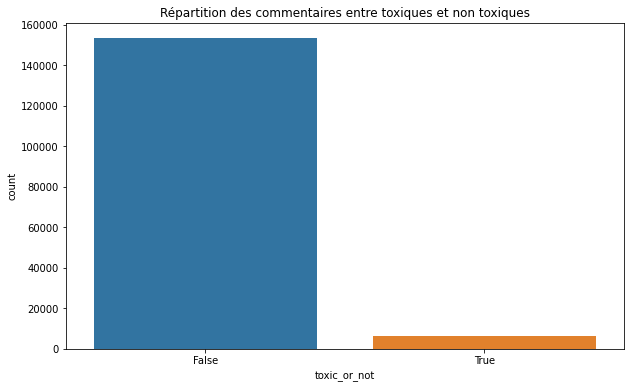

In [0]:
rowsums = train.iloc[:,2:].sum(axis=1)
train['toxic_or_not'] = (rowsums==1) # True si le commentaire est toxique False sinon

plt.figure(figsize=(10,6))
ax = sns.countplot(data = train, x = 'toxic_or_not')
plt.title("Répartition des commentaires entre toxiques et non toxiques")
rects = ax.patches

On remarque qu'il y a beaucoup plus de commentaires non toxiques que toxiques (~150k versus ~16k). Cela pose un premier problème de déséquilibre entre les classes. Il sera important de prendre en compte cette répartition lors du choix de l'algorithme de classification.

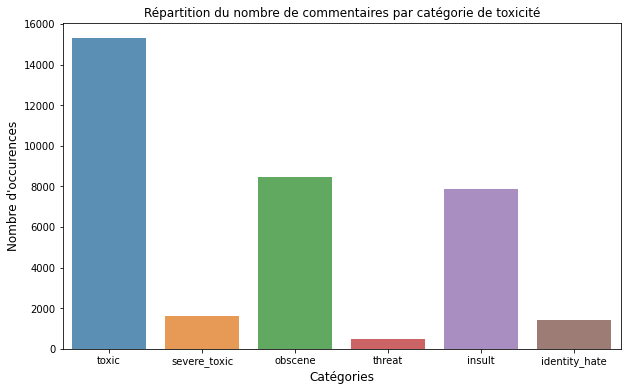

In [0]:
cat = y_train.iloc[:,1:].sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(cat.index, cat.values, alpha=0.8)
plt.title("Répartition du nombre de commentaires par catégorie de toxicité")
plt.ylabel("Nombre d'occurences", fontsize=12)
plt.xlabel("Catégories", fontsize=12)
rects = ax.patches

Egalement, nous observons un déséquilibre parmi les types de toxicités (par exemple, il y a beaucoup moins de commentaires "threat" ou "severe toxic" que de commentaire "toxic" ou "obscene").

Nous observons enfin qu'il y a ~16k de commentaires toxiques mais que la somme des répartition du nombre de commentaires par catégorie de toxicité s'élève à ~35k, cela est seulement possible lorsqu'un commentaire est assimilé à plusieurs classes.

#### <u>Multi-label classification</u>

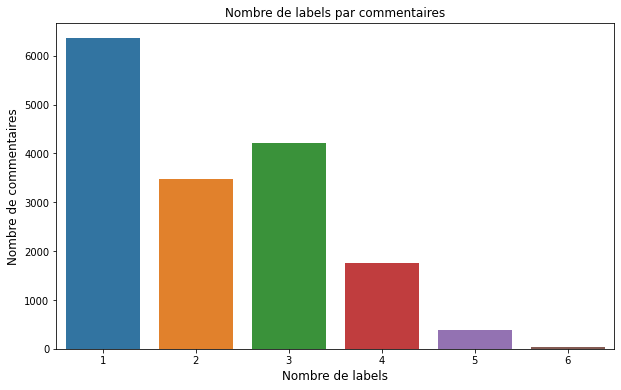

In [0]:
multi_label = y_train.iloc[:,1:].sum(axis=1).value_counts()

plt.figure(figsize=(10,6))
ax = sns.barplot(multi_label.index[1:], multi_label.values[1:])
plt.title("Nombre de labels par commentaires")
plt.xlabel("Nombre de labels", fontsize=12)
plt.ylabel("Nombre de commentaires", fontsize=12)
rects = ax.patches

On remarque que la plupart des commentaires labelisés ont 1 seul label, il est presque aussi courant de rencontrer des commentaires avec 2 ou 3 labels de toxicité. En revanche, les commentaires ayant plus de 3 labels se font déjà plus rares. Enfin, il y a des commentaires avec les 6 labels. 
Rappelons cependant que les plupart des commentaires sont considérés comme "clean", c'est-à-dire qu'ils ont 0 labels de toxicité.


On peut donc en déduire que la plupart des commentaires auront plusieurs labels, et de ce fait cela complique notre classification car il ne s'agit pas de classifier chaque commentaire comme appartenant à une classe plutôt qu'à une autre car un commentaire peut appartenir à plusieurs classes à la fois. 
Il faudra donc prendre en compte cette caractéristique importante.

### **<u>I.2 Analyse des commmentaires</u>**



In [0]:
eng_stopwords = set(stopwords.words('english'))
eng_stopwords.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

df = pd.DataFrame()
df['toxic_or_not'] = train['toxic_or_not']

#### <u> Impact de la longueur d'un commentaire sur sa toxicité et son type </u>

Dans un premier temps, nous analysons l'impact de la longeur d'un commentaire, à travers le nombre de paragraphes et de mots, tout d'abord pour savoir si le commentaire a une dimension toxique ou non, puis pour déterminer le type de toxicité. 

In [0]:
df['count_paraph'] = train["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1) 
df['count_word']= train["comment_text"].apply(lambda x: len(str(x).split()))
df['count_paraph'].loc[df['count_paraph']>10] = 10
df['count_word'].loc[df['count_word']>200] = 200

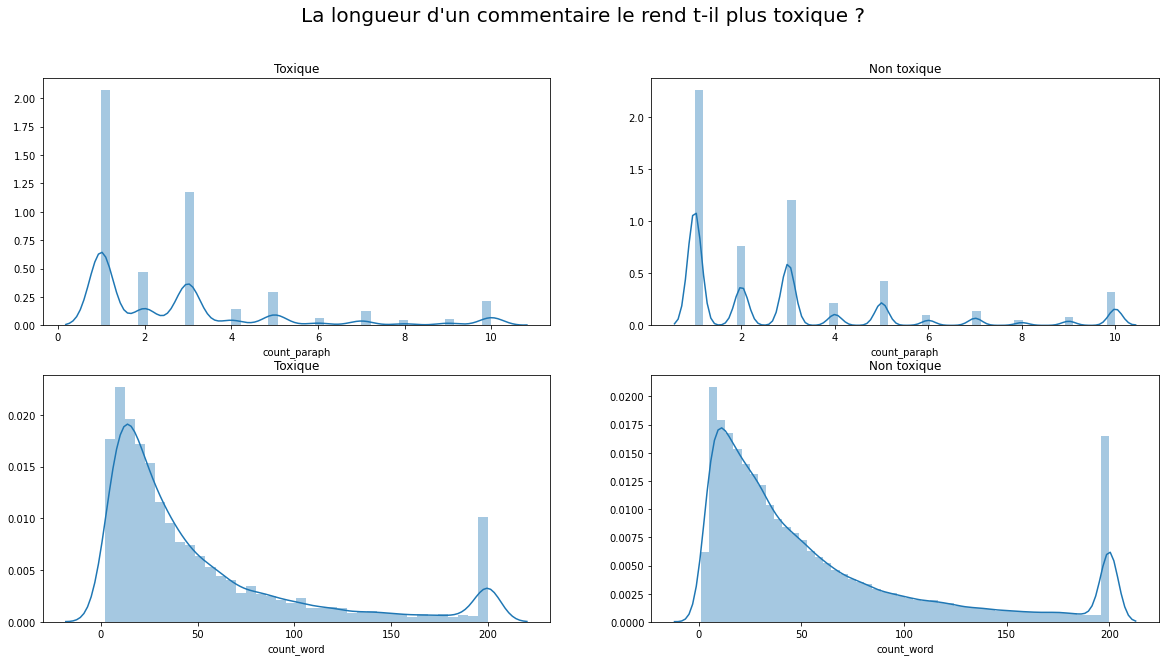

In [0]:
plt.figure(figsize=(20,10))
plt.suptitle("La longueur d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_paraph'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_paraph'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_word'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_word'])
plt.show()

Nous observons que le nombre de paragraphes n'a pas d'impact significatif sur la toxicité d'un commentaire : qu'il soit toxique ou non, la distribution de la taille des paragraphes est la même.

En ce qui concerne le nombre de mots, la différence est plus marquée. En effet, les commentaires non-toxiques semblent contenir davantage de mots.

On peut donc en déduire que la longueur des commentaires peut nous aider légèrement à déterminer si un commentaire est toxique ou non. Nous allons désormais chercher à savoir si elle nous permet de déterminer le type de toxicité du commentaire.

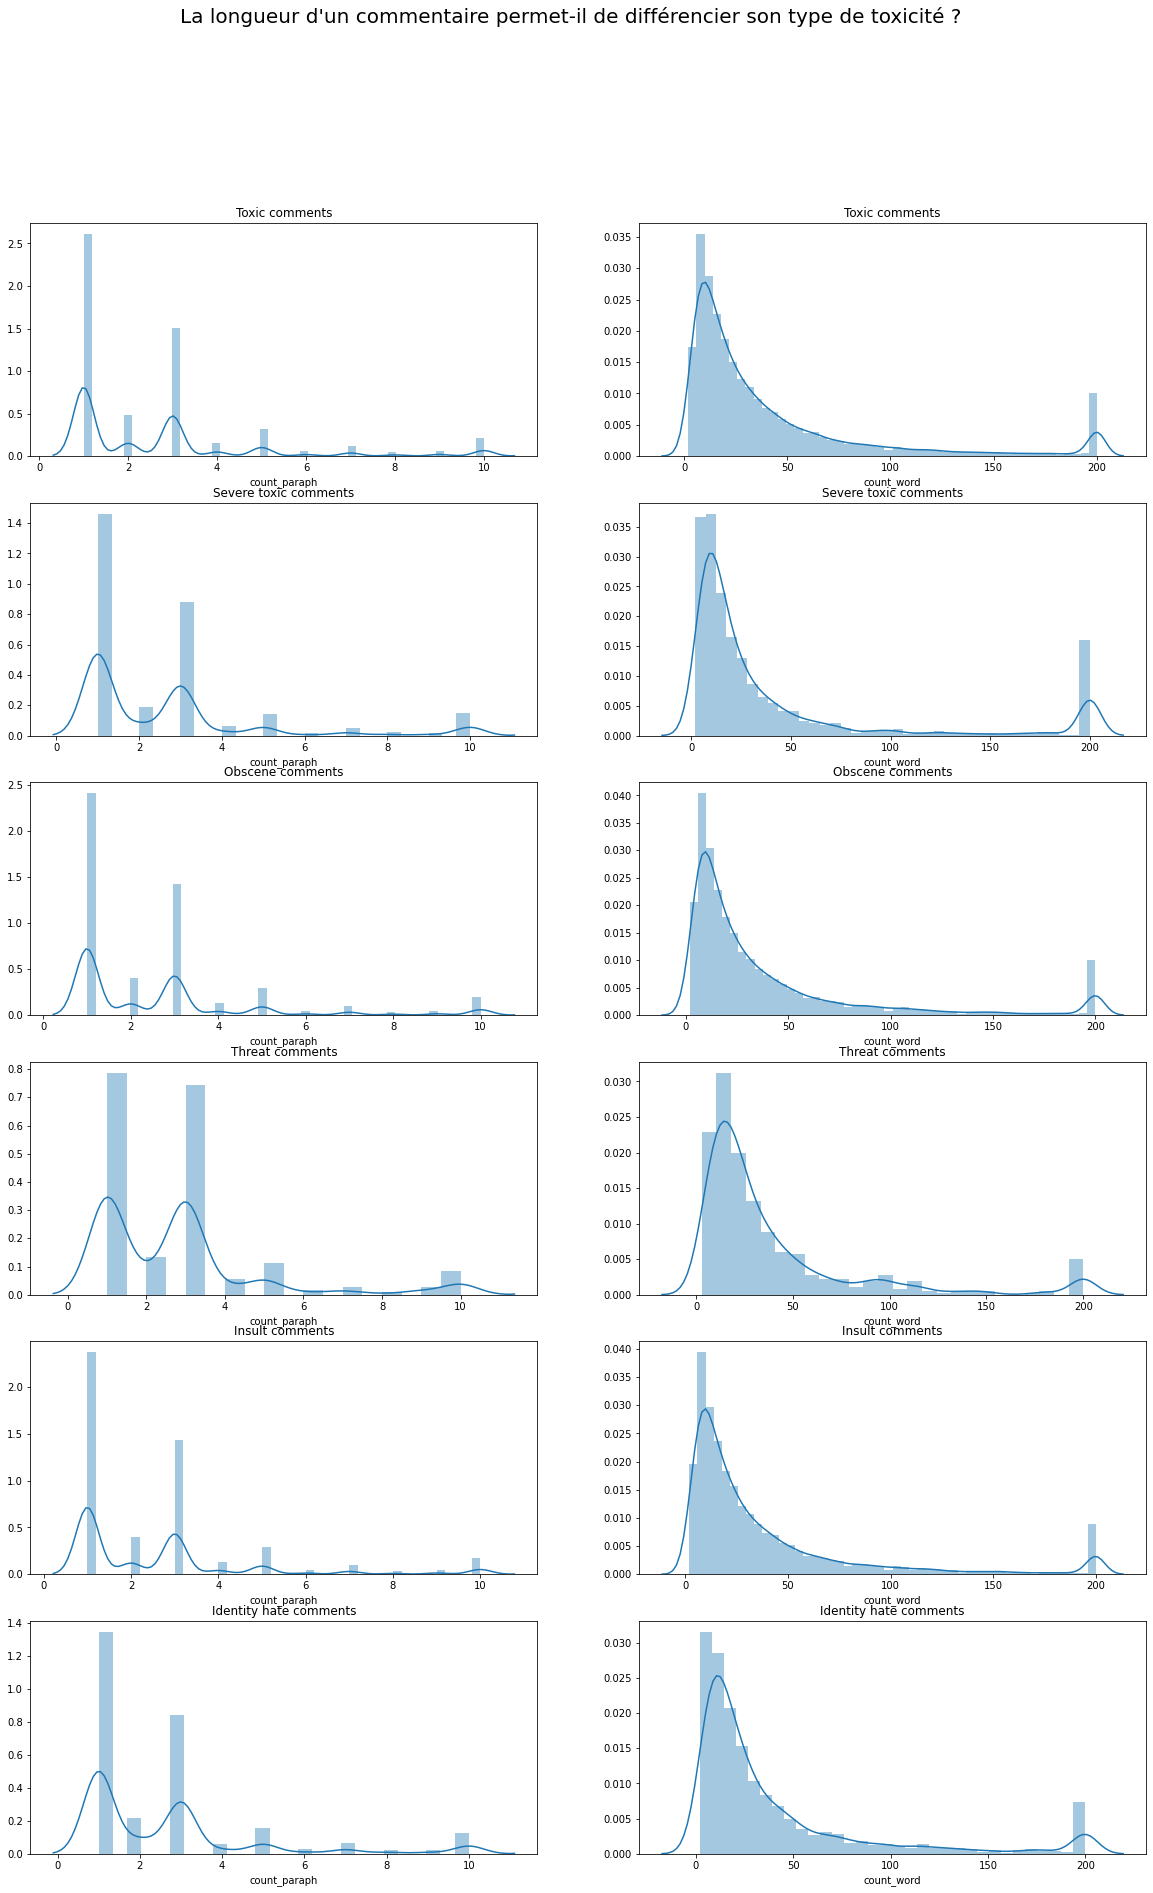

In [0]:
plt.figure(figsize=(20,30))
plt.suptitle("La longueur d'un commentaire permet-il de différencier son type de toxicité ?", fontsize = 20)
plt.subplot(621)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_paraph'])
plt.subplot(622)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_word'])
plt.subplot(623)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_paraph'])
plt.subplot(624)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_word'])
plt.subplot(625)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_paraph'])
plt.subplot(626)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_word'])
plt.subplot(627)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_paraph'])
plt.subplot(628)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_word'])
plt.subplot(629)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_paraph'])
plt.subplot(6,2,10)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_word'])
plt.subplot(6,2,11)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_paraph'])
plt.subplot(6,2,12)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_word'])
plt.show()

Tout comme pour la toxicité, la longueur des commentaires ne nous semble pas significativement influencer le type de toxicité du commentaire. 

En revanche, on peut remarquer des distributions légèrement différentes pour certains types de toxicité, comme les insultes qui ont tendance à être des commentaires plus courts par exemple. 

Nous avons donc décidé de garder les deux variables permettant de qualifier la longueur des commentaires. 

#### <u> Impact de l'aggressivité d'un commentaire sur sa toxicité et son type </u>

Nous allons désormais analyser l'impact de l'agressivité des commentaires, qualifiée par le nombre de ponctuations et de mots en majuscule, sur la toxicité et le type de toxicité des commentaires.

In [0]:
df['count_punctuations'] = train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) # on compte le nombre de ponctuations dans un commentaire
df['count_words_upper'] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()])) # on compte le nombre de mots en majuscule dans un commentaire
df['propor_punctuations'] = df['count_punctuations'] / df['count_word'] 
df['propor_words_upper'] = df['count_words_upper'] / df['count_word']
df['propor_punctuations'].loc[df['propor_punctuations']>2] = 2
df['propor_words_upper'].loc[df['propor_words_upper']>1] = 1

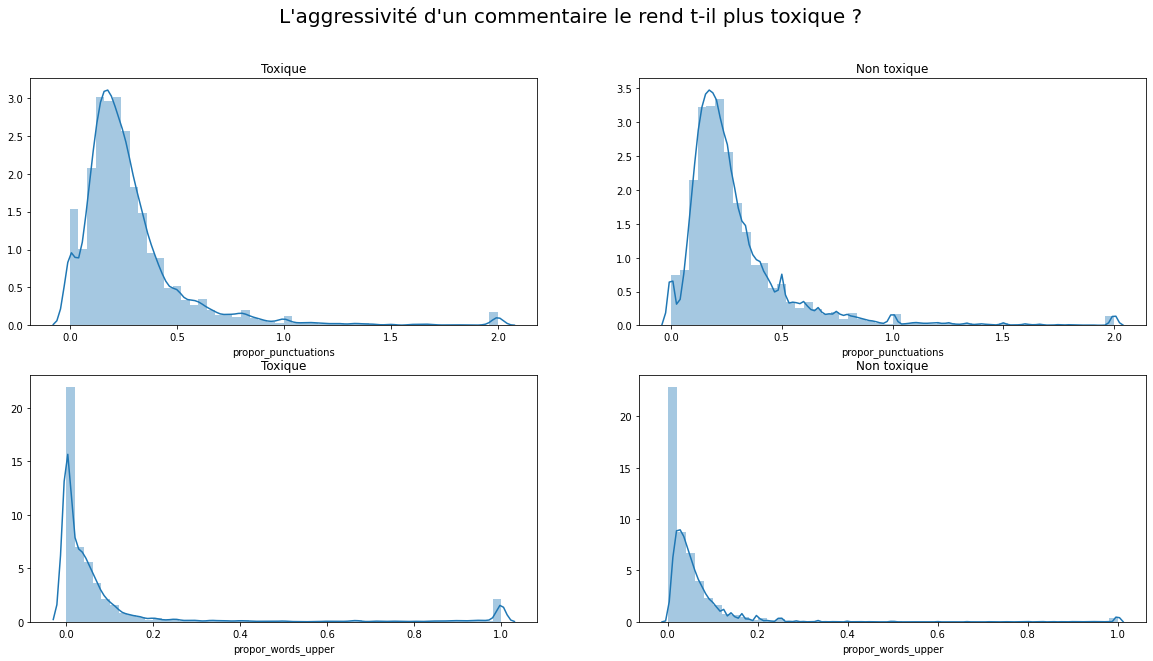

In [0]:
plt.figure(figsize=(20,10))
plt.suptitle("L'aggressivité d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['propor_punctuations'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['propor_punctuations'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['propor_words_upper'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['propor_words_upper'])
plt.show()

Nous observons que la proportion de ponctuations parmi le nombre de mots utilisés a un faible impact sur la toxicité du commentaire. 

En revanche, même si la distribution de la proportion de mots en majuscule nous semble relativement similaire pour les commentaires toxiques et non-toxiques, on remarque que les commentaires comportant uniquement des mots en majuscule (proportion de mots en majuscule égale à 1) sont généralement toxiques.

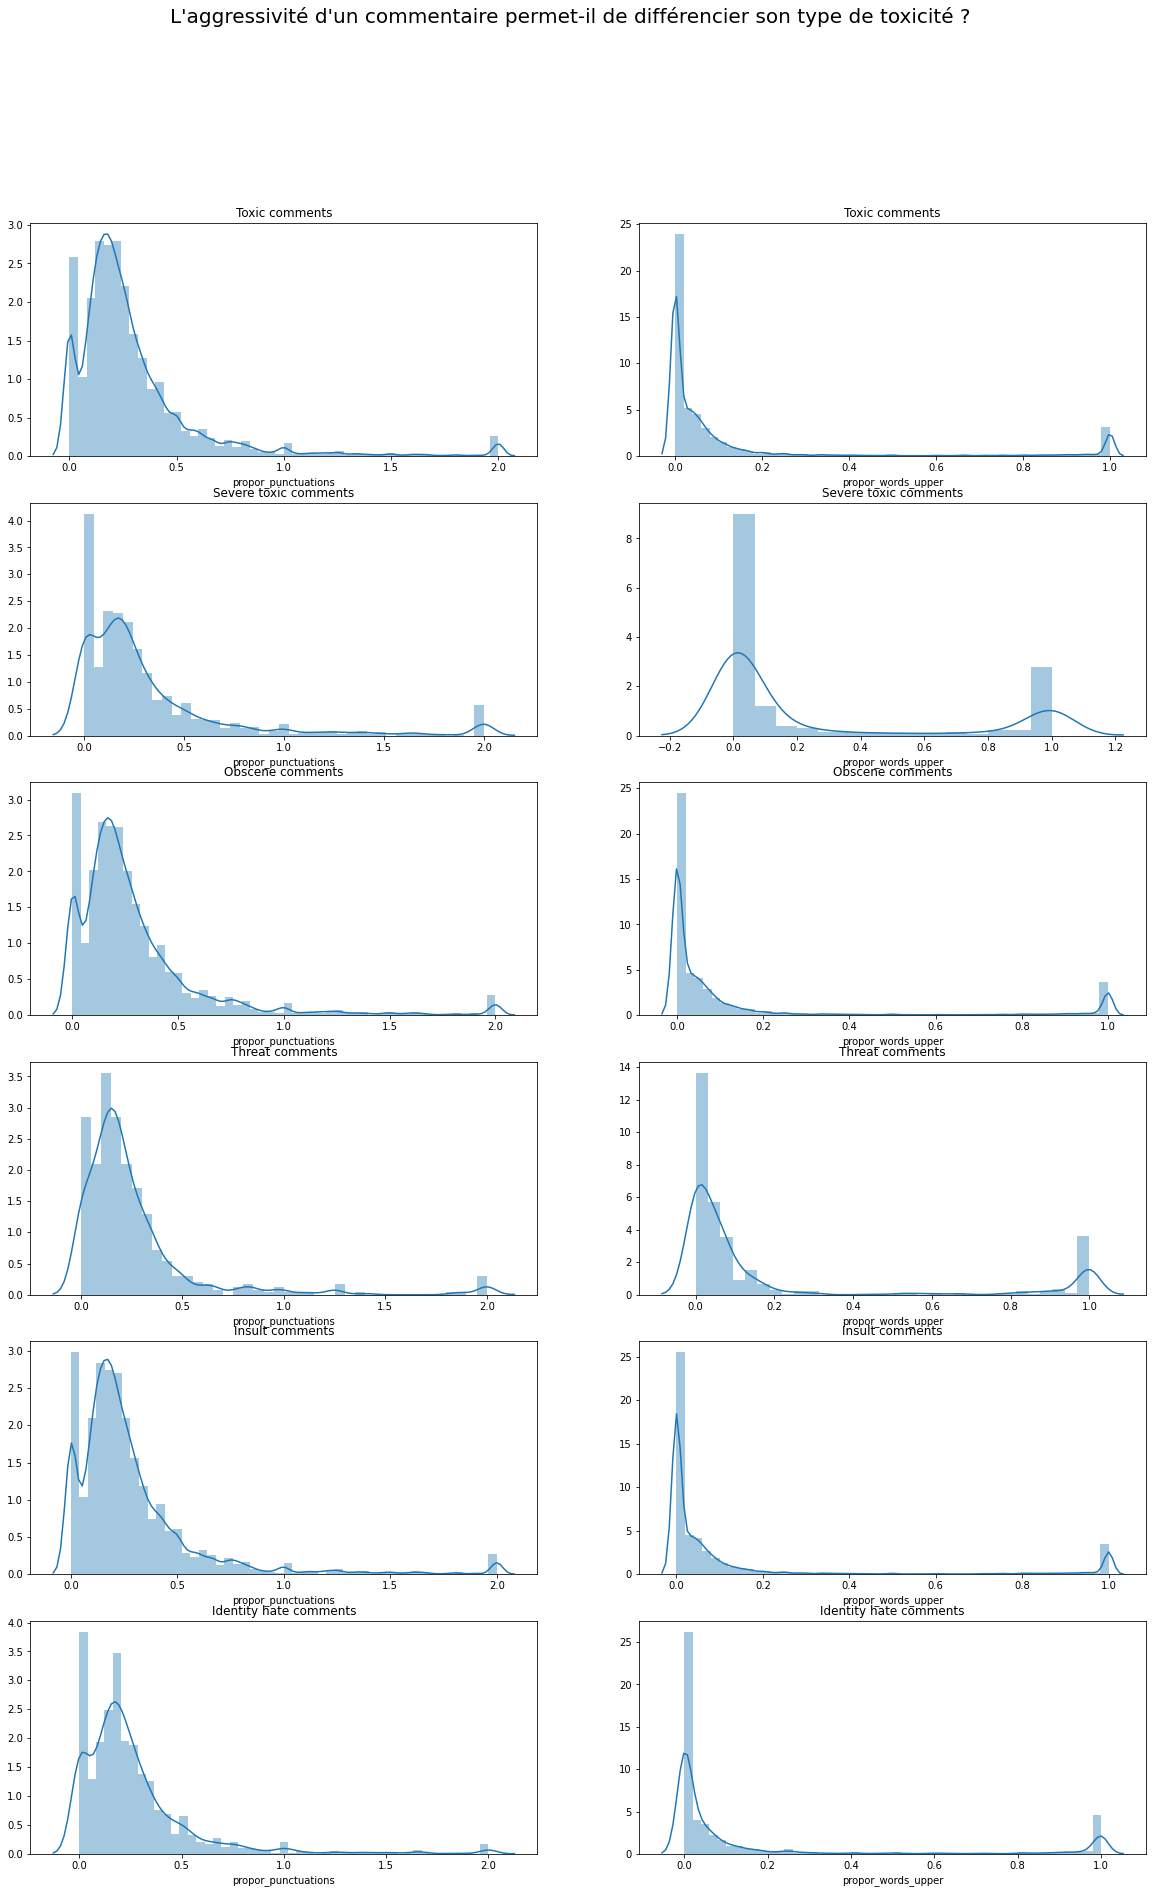

In [0]:
plt.figure(figsize=(20,30))
plt.suptitle("L'aggressivité d'un commentaire permet-il de différencier son type de toxicité ?", fontsize = 20)
plt.subplot(621)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['propor_punctuations'])
plt.subplot(622)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['propor_words_upper'])
plt.subplot(623)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['propor_punctuations'])
plt.subplot(624)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['propor_words_upper'])
plt.subplot(625)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['propor_punctuations'])
plt.subplot(626)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['propor_words_upper'])
plt.subplot(627)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['propor_punctuations'])
plt.subplot(628)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['propor_words_upper'])
plt.subplot(629)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['propor_punctuations'])
plt.subplot(6,2,10)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['propor_words_upper'])
plt.subplot(6,2,11)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['propor_punctuations'])
plt.subplot(6,2,12)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['propor_words_upper'])
plt.show()

Comme nous l'avions observé dans la détermination de la toxicité des commentaires, l'agressivité d'un commentaire permet de déterminer le type de toxicité. 

En effet, on remarque que les commentaires très toxiques et de menace comportent davantage de mots en majuscule, et les insultes comportent davantage de ponctuations. 

Ces variables explicatives sont donc importantes pour notre classification.

#### <u> Impact du champs lexical d'un commentaire sur sa toxicité et son type </u>

Enfin nous allons analyser l'impact de la richesses du champs lexical sur la toxicité des commentaires, en étudiant le nombre de stopwords et de mots uniques utilisés.

In [0]:
df['count_stopwords'] = train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords])) # on compte le nombre de stopwords dans un commentaire
df['count_unique_word'] = train["comment_text"].apply(lambda x: len(set(str(x).split()))) # on compte le nombre de mots uniques dans un commentaire
df['count_stopwords'].loc[df['count_stopwords']>100] = 100
df['count_unique_word'].loc[df['count_unique_word']>100] = 100

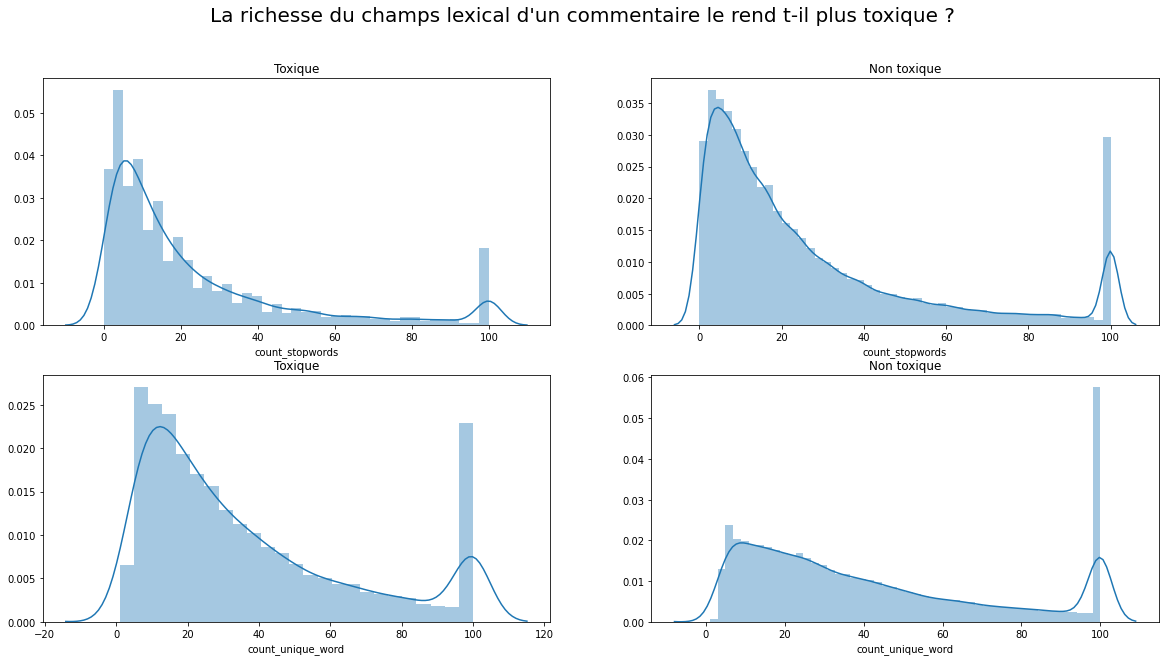

In [0]:
plt.figure(figsize=(20,10))
plt.suptitle("La richesse du champs lexical d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_stopwords'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_stopwords'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_unique_word'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_unique_word'])
plt.show()

On constate que la richesse du champs lexical employé dans les commentaires toxiques et non-toxiques est significativement différentes.

En effet, en ce qui concerne le nombre de stopwords employés, généralement utilisés dans les phrases bien construites, est plus important dans les commentaires non-toxiques.

De plus, les commentaires toxiques ont tendance à comporter beaucoup moins de mots uniques. 

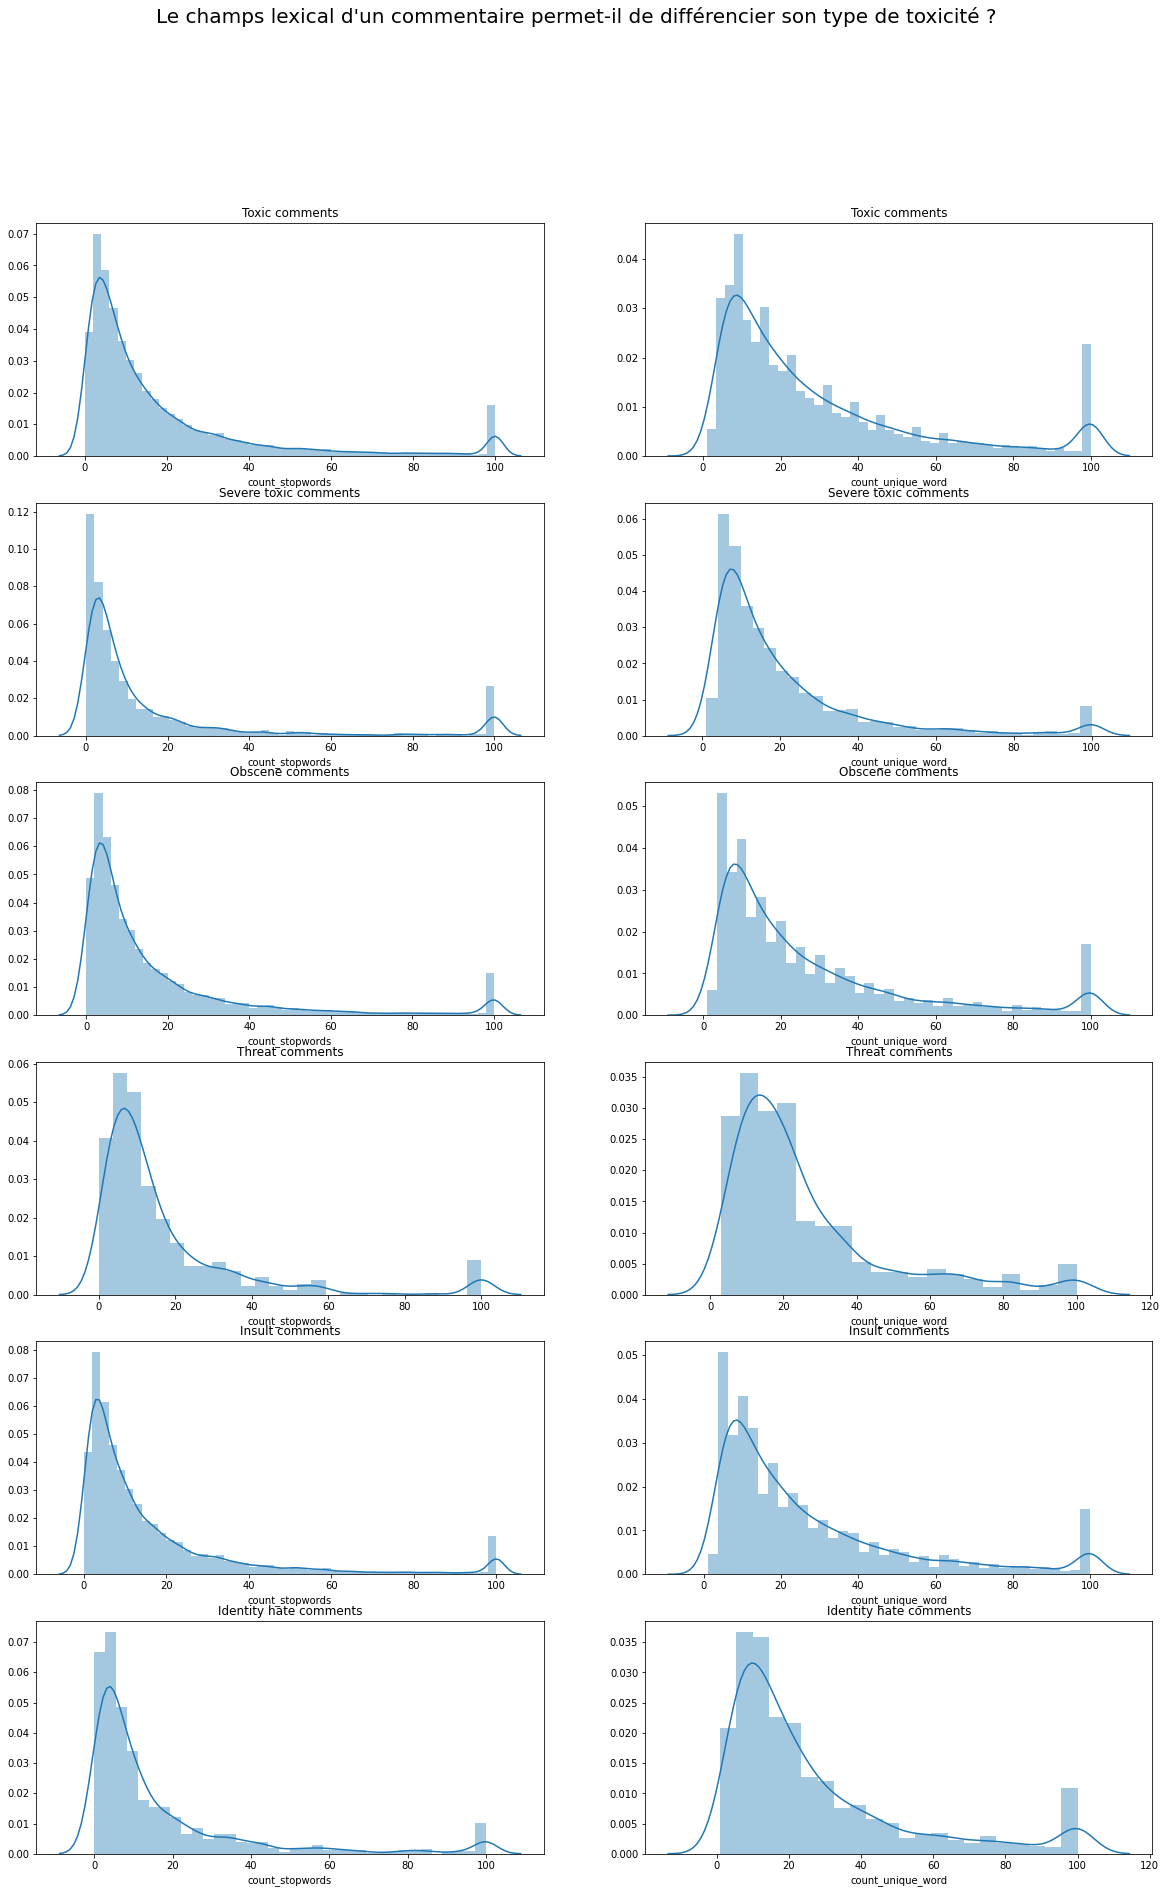

In [0]:
plt.figure(figsize=(20,30))
plt.suptitle("Le champs lexical d'un commentaire permet-il de différencier son type de toxicité ?", fontsize = 20)
plt.subplot(621)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_stopwords'])
plt.subplot(622)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_unique_word'])
plt.subplot(623)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_stopwords'])
plt.subplot(624)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_unique_word'])
plt.subplot(625)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_stopwords'])
plt.subplot(626)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_unique_word'])
plt.subplot(627)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_stopwords'])
plt.subplot(628)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_unique_word'])
plt.subplot(629)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_stopwords'])
plt.subplot(6,2,10)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_unique_word'])
plt.subplot(6,2,11)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_stopwords'])
plt.subplot(6,2,12)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_unique_word'])
plt.show()

La richesse du champs lexical nous permet d'identifier les types de toxicité des commentaires.

En effet, on remarque que les commentaires très toxiques comportent moins de stopwords, alors que les menaces en comportent davantage que les commentaires avec d'autres types de toxicité. 

Les menaces comportent également beaucoup plus de mots uniques, tous comme les commentaires de haine identitaires.

#### <u> Conclusion sur les variables explicatives </u>

Nous observons que l'aggressivité (nombre de ponctuations et de mots en majuscule) et la richesse du champs lexical (nombre de mots uniques et de stopwords) ont un impact significatif sur la détermination de la toxicité d'un commentaire ou non. 

Ces variables nous semblent être efficaces dans la classification de la toxicité d'un commentaire. En revanche cela ne semble pas être le cas pour la longueur d'un commentaire, nous décidons toute de fois de pousser l'analyse des variables qui la caractérisent (nombre de paragraphes et de mots).

## **<u> II - Word-level preprocessing et nettoyage</u>**

à rédiger au propre 

### **II.1 Tokenization**

In [0]:
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer()]

for tok in tokenizers:
    arr = train.comment_text.apply(lambda x: tok.tokenize(x)).array
    arr = reduce(add, arr)
    print("Taille du vocabulaire : {0}, avec le tokenizer {1}".format(len(set(arr)), tok))  

Taille du vocabulaire : 12925, avec le tokenizer <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x0000024FDB86C588>
Taille du vocabulaire : 12827, avec le tokenizer <nltk.tokenize.toktok.ToktokTokenizer object at 0x0000024FDB8603C8>
Taille du vocabulaire : 11904, avec le tokenizer <nltk.tokenize.casual.TweetTokenizer object at 0x0000024FDB85D3C8>


### **<u>II.3 WordCloud</u>**

**Toxic comments :**

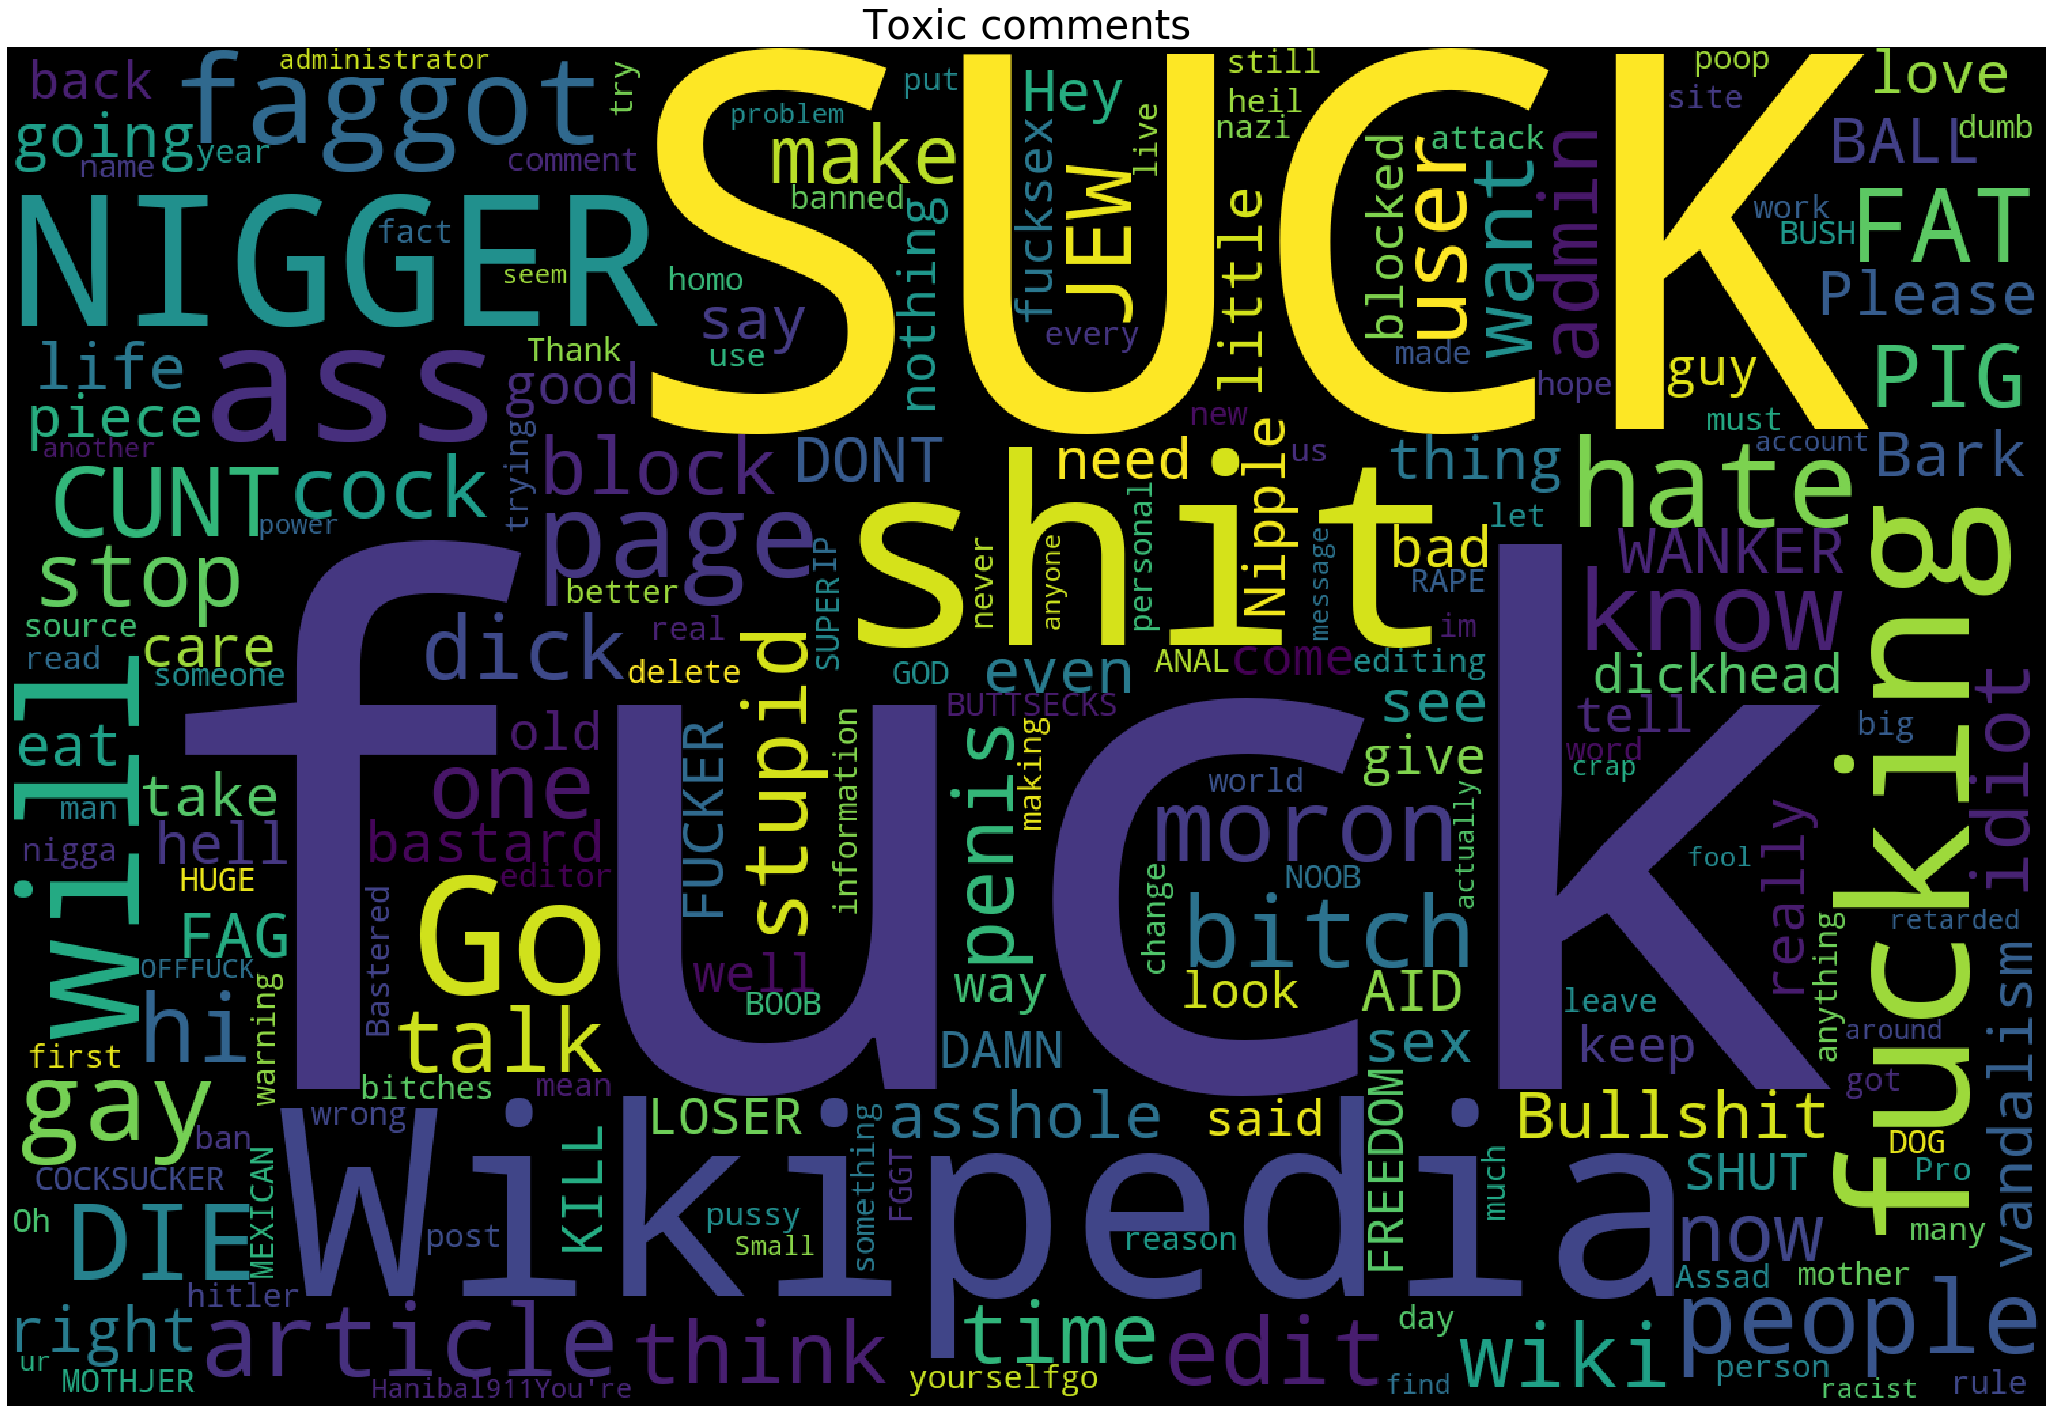

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['toxic']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Toxic comments', fontsize = 40)
plt.imshow(cloud)

**Severe toxic comments :**

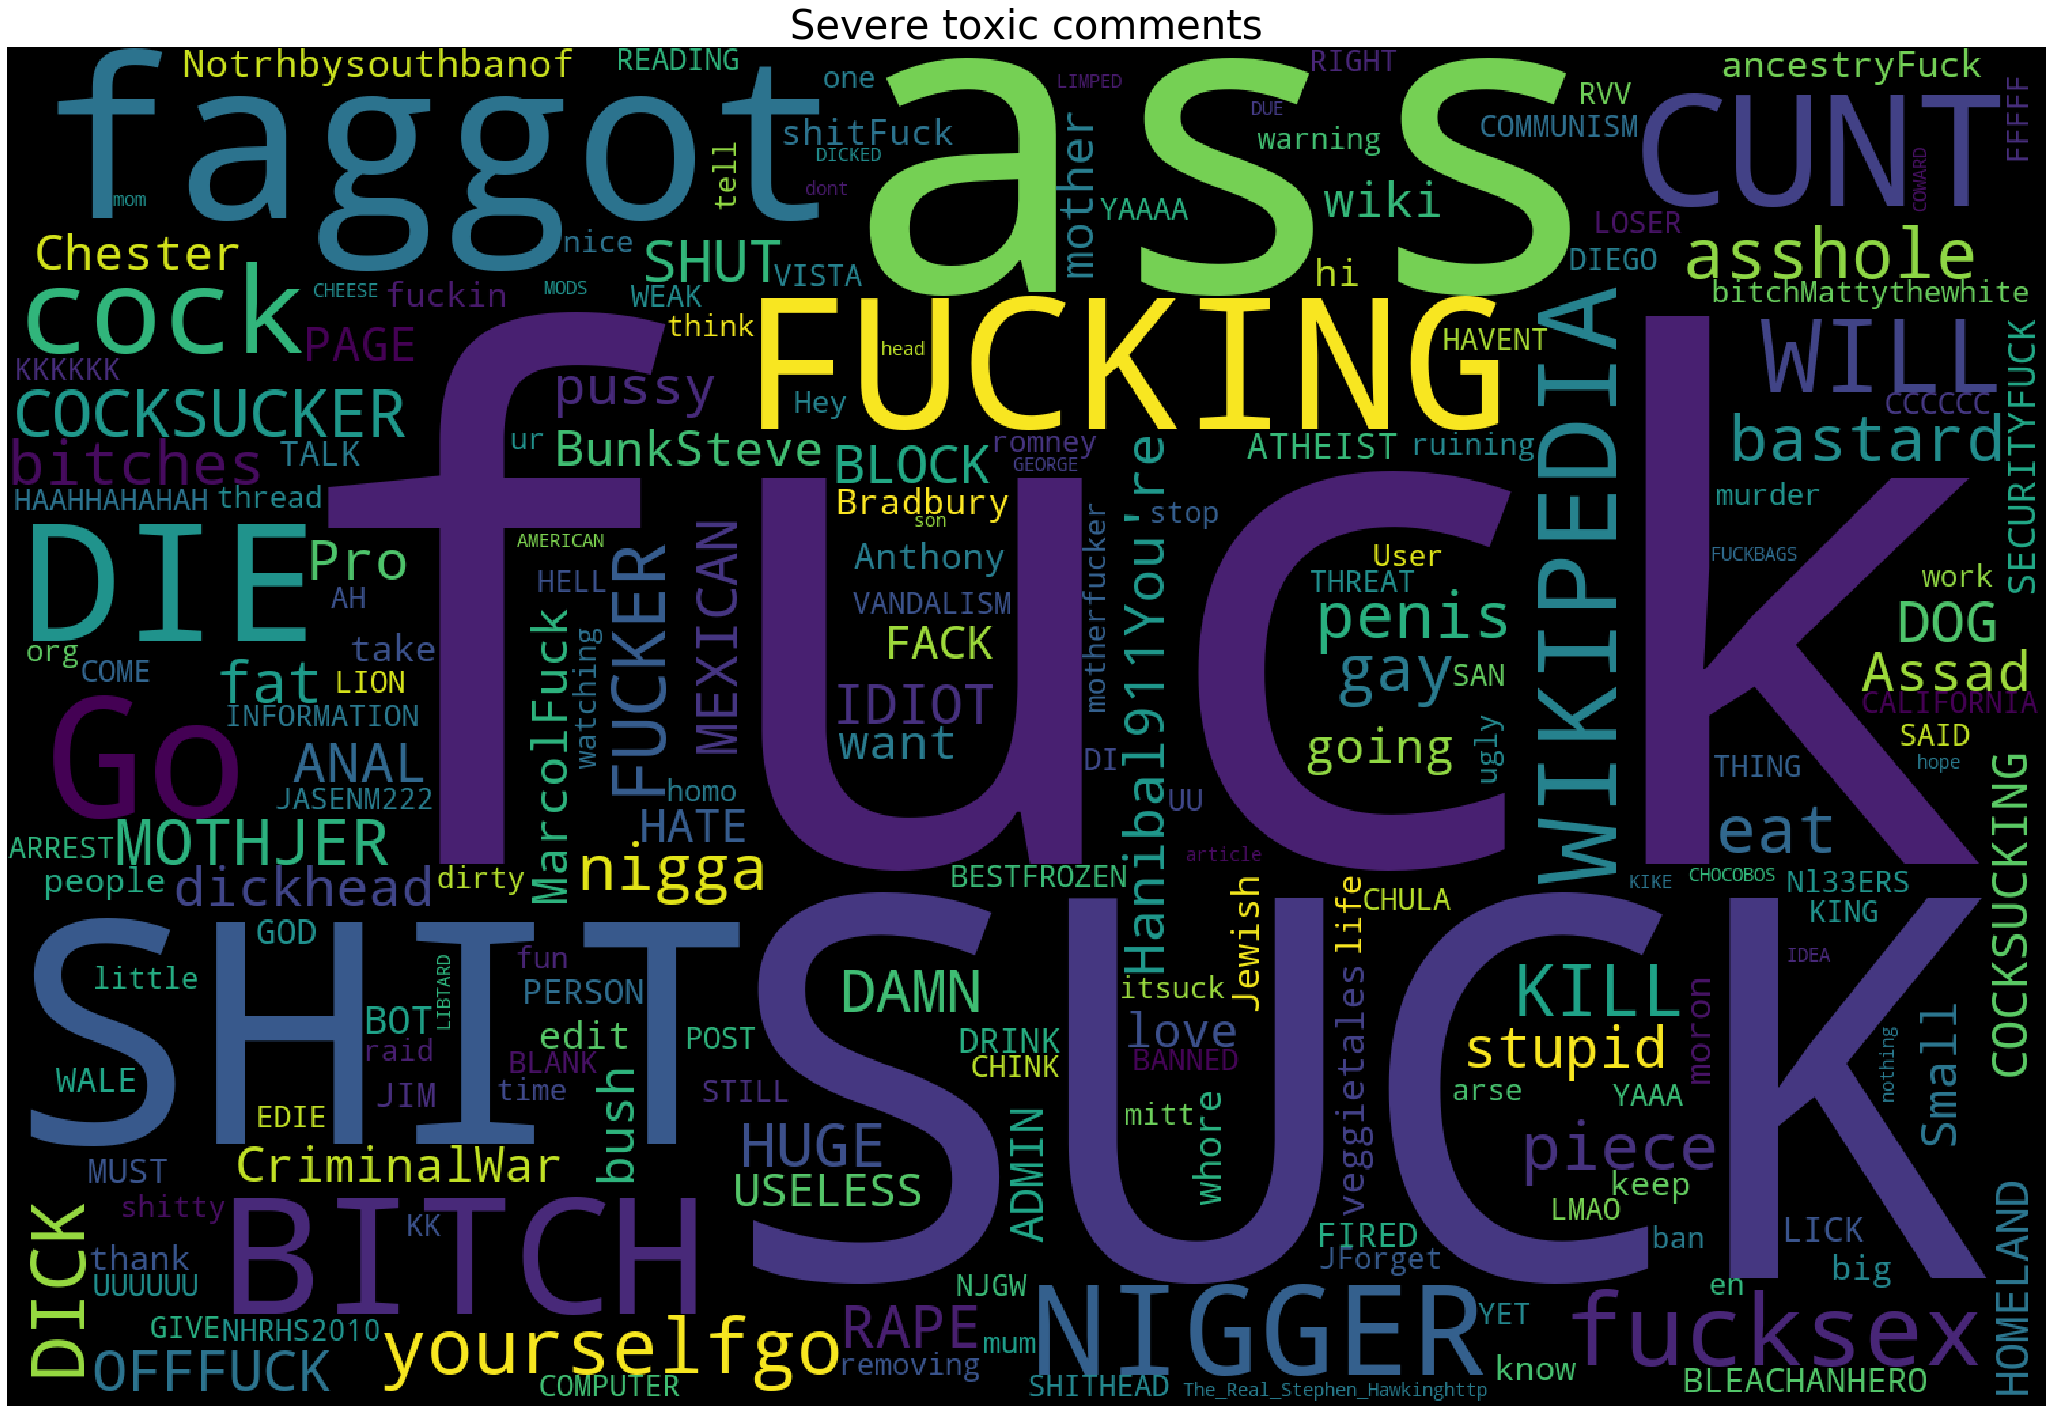

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['severe_toxic']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Severe toxic comments', fontsize = 40)
plt.imshow(cloud)

**Obscene comments :**

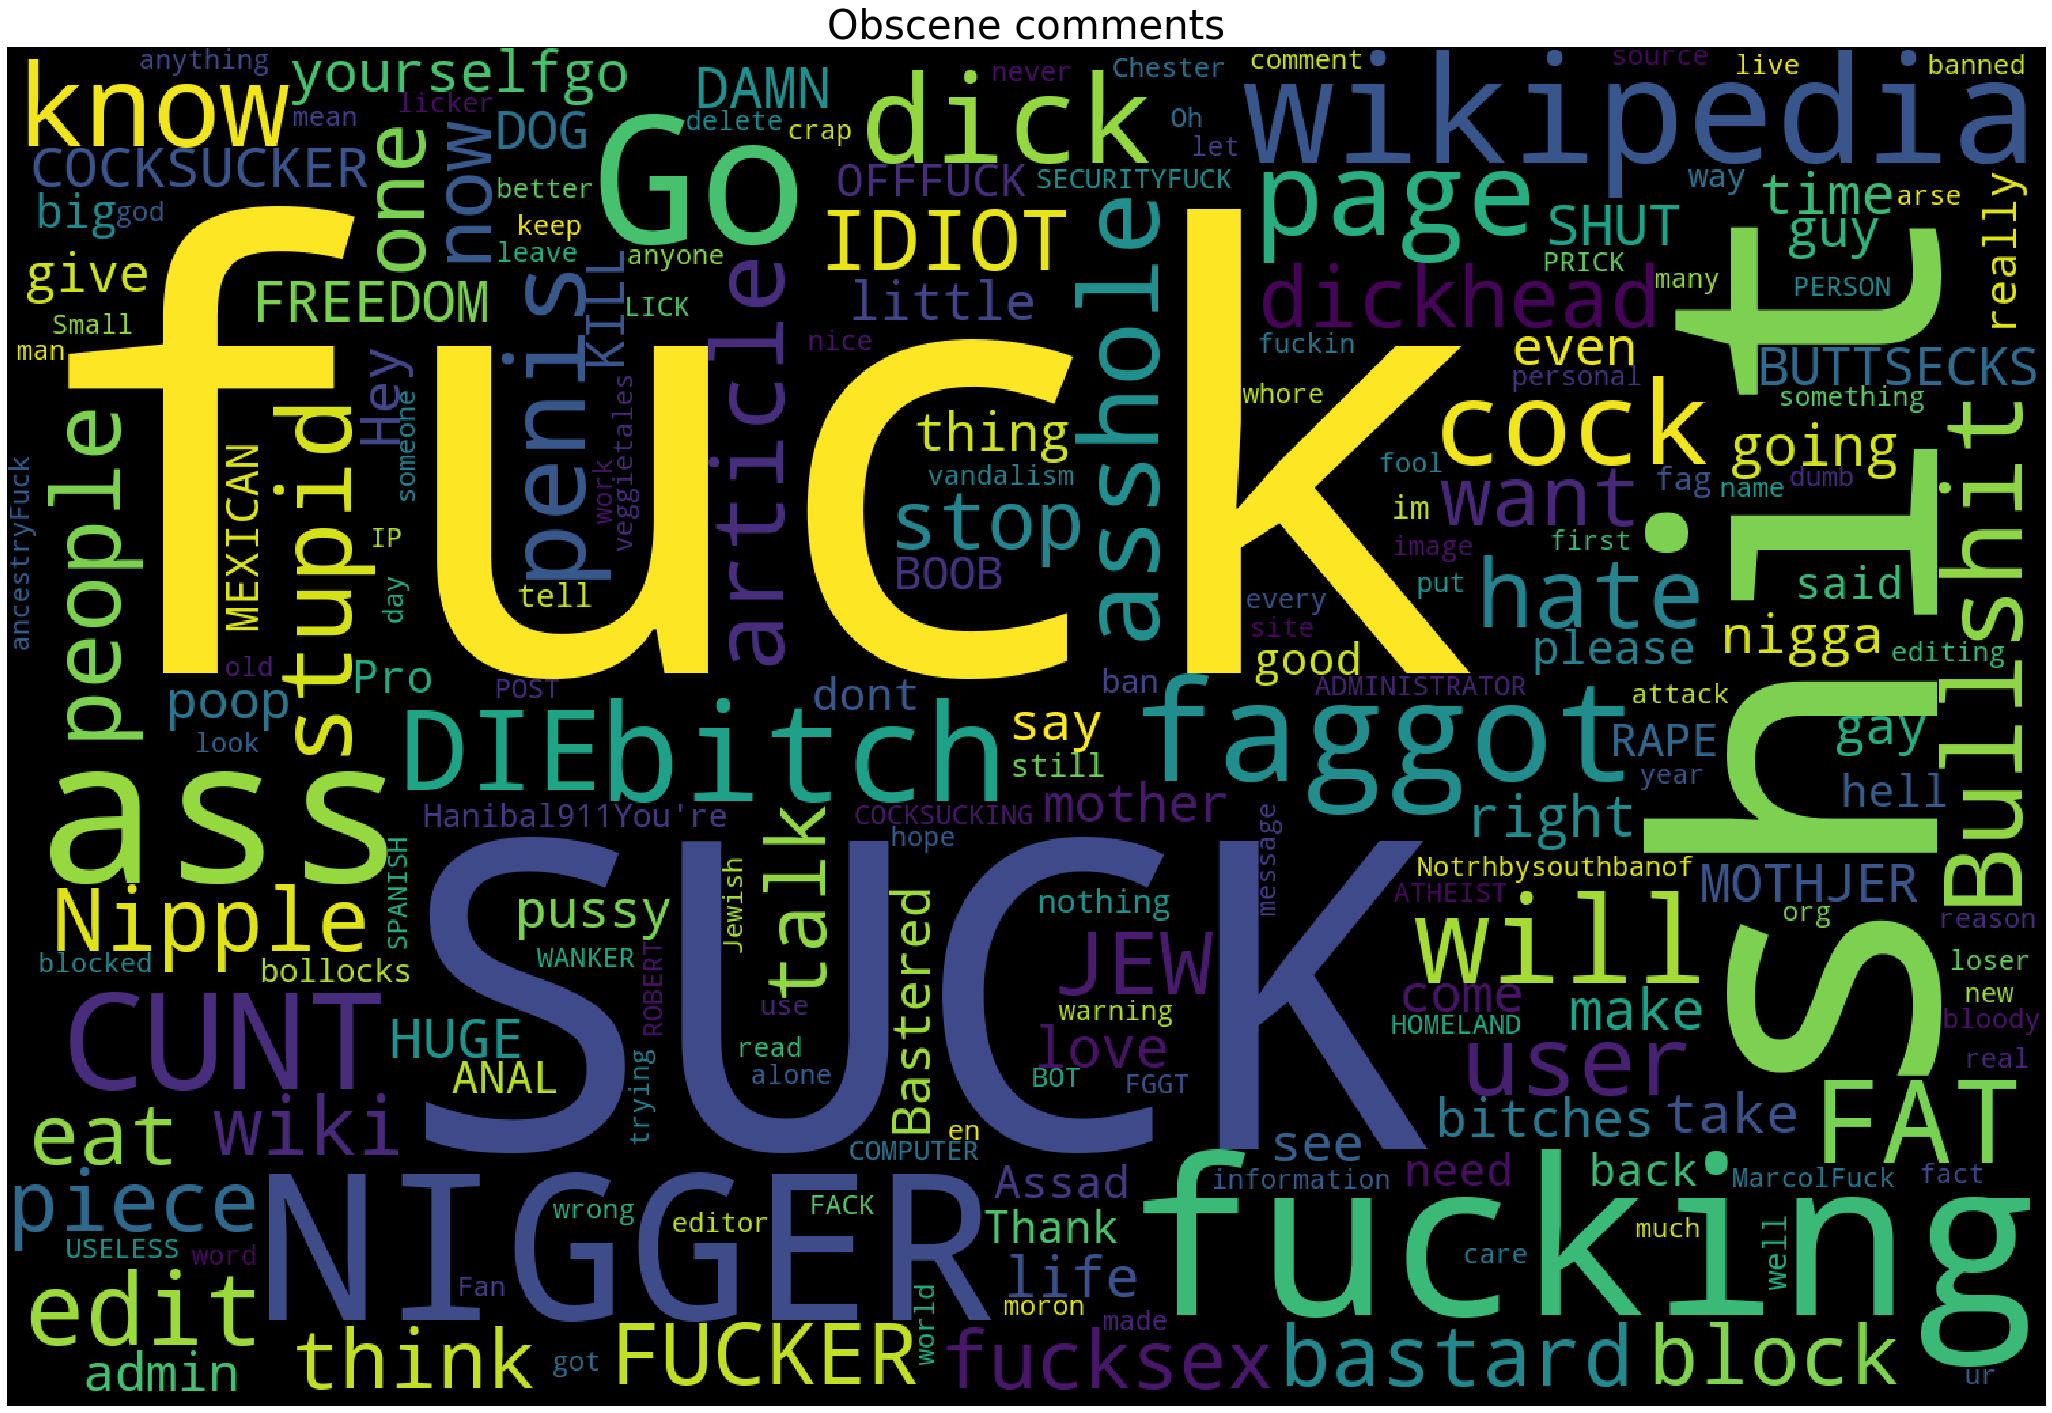

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['obscene']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Obscene comments', fontsize = 40)
plt.imshow(cloud)

**Threat comments :**

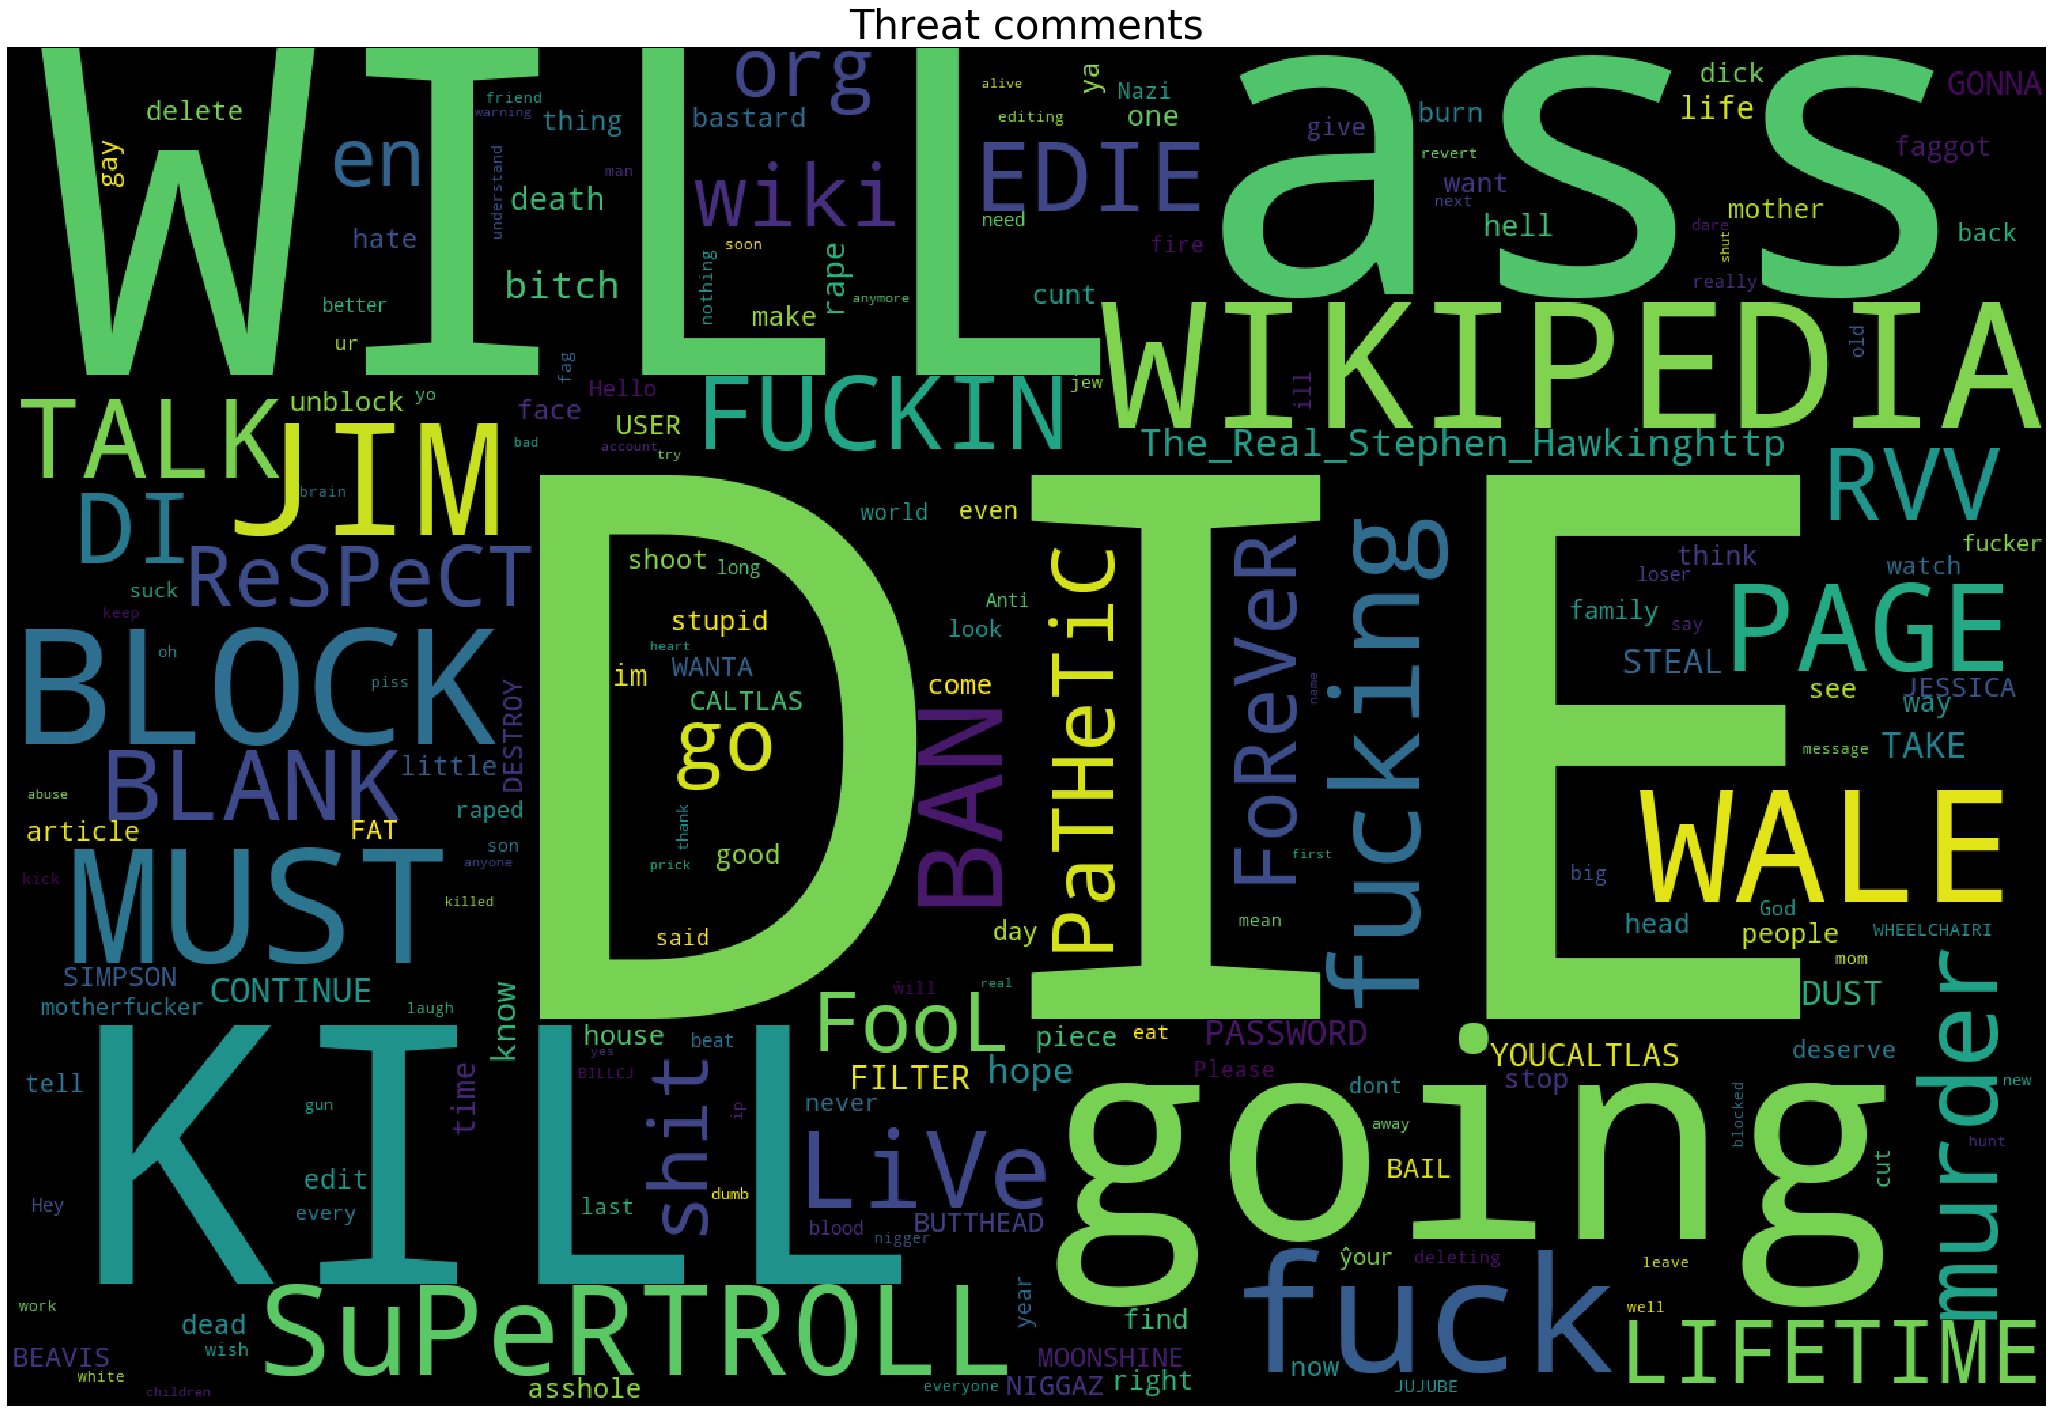

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['threat']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Threat comments', fontsize = 40)
plt.imshow(cloud)

**Insult comments :**

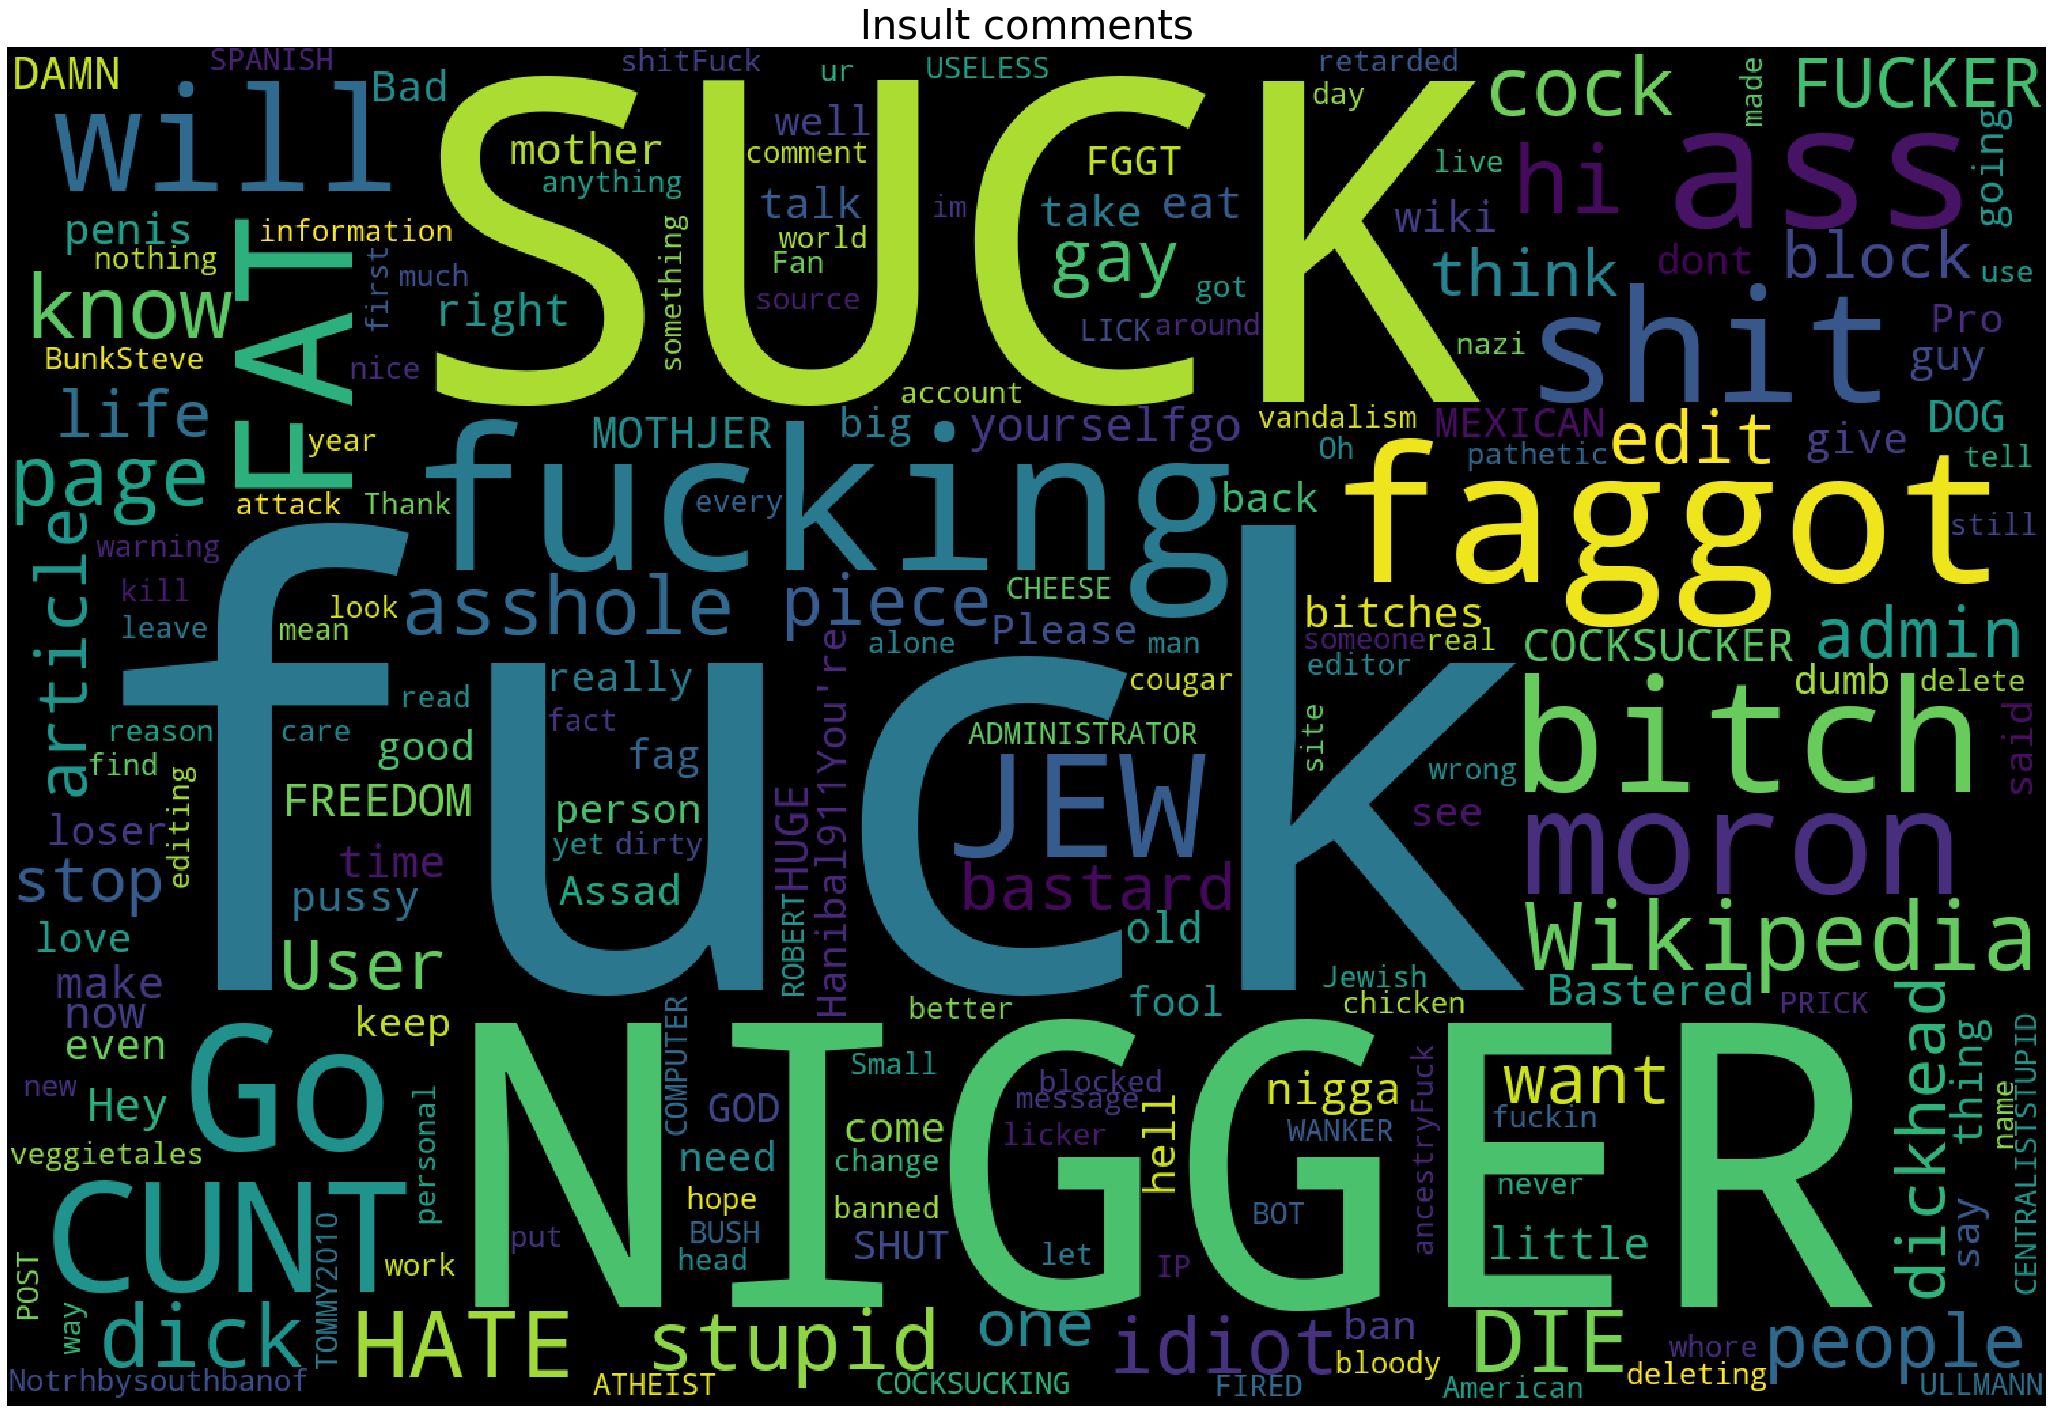

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['insult']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Insult comments', fontsize = 40)
plt.imshow(cloud)

**Identity hate comments :**

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['identity_hate']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Identity hate comments', fontsize = 40)
plt.imshow(cloud)

NameError: ignored